In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
mnist = tf.keras.datasets.mnist
(images, targets), (images_valid, targets_valid) = mnist.load_data()
images, images_valid= images / 255.0, images_valid / 255.0


In [15]:
images=images.reshape(-1,28,28,1)

In [16]:
images.shape

(60000, 28, 28, 1)

In [17]:
# On selectionne un echantillon de 12 images au hasard
images_demo = images.reshape((-1, 28, 28))
select = np.random.randint(images.shape[0], size=12)

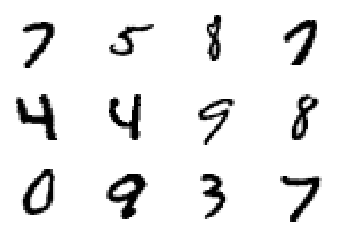

In [18]:
# On affiche les images 
for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(images_demo[value],cmap=plt.cm.gray_r,interpolation="nearest")
    

plt.show()

In [19]:
print("Moyenne et écart-type des images", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Moyenne et écart-type des images remise à l'échelle", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Moyenne et écart-type des images 0.1306604762738429 0.3081078038564622
Moyenne et écart-type des images remise à l'échelle 5.1098400794094047e-14 0.956316274213992


In [20]:
#on crée un dataset pour les manipulations dans tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images)
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

In [21]:
#taille de chaque composante du dataset image de 28 par 28 avec une catégorie, la cible
for item in train_dataset:
    print(item.shape)
    break

(28, 28, 1)


In [22]:
# Itération sur le dataset  avec un nombre d'époch et une taille de batch

epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break



(32, 28, 28, 1)


In [23]:
#on crée maintenant le train set pour tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))

In [24]:
train_dataset.batch

<bound method DatasetV2.batch of <TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>>

In [25]:
# et on recommence sur le train set des itérations avec epoch et batch
epoch = 1
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break


(32, 28, 28, 1) (32,)


In [26]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(10, activation='softmax', name="output")

    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

In [27]:
model = ConvModel()
model.predict(scaled_images[0:1])

array([[0.10384555, 0.0987796 , 0.10573256, 0.10246237, 0.0886752 ,
        0.0971439 , 0.10572062, 0.09265122, 0.11254657, 0.09244239]],
      dtype=float32)

In [28]:
#on chosit notre métrique de fonction de cout ici par Cross Entropie
#et on choisit notre optimizer pour la descente de gradient afin de calculer les poids 
# optimum dans le réseau entièrement connecté
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [29]:
#on chosit nos métriques pour voir la progression de la convergence du train set et du validation set
# Loss : erreur moyenne commise
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy : précision 
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [30]:
#on entraine le modèle
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_object(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)


In [31]:
#on passe par la validation
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

In [32]:
epoch = 3
batch_size = 32
b = 0
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 Batch 59968/60000, Loss: 0.11103404313325882, Accuracy: 96.79000091552734
Epoch 1, Valid Loss: 0.052142418920993805, Valid Accuracy: 98.25999450683594
 Batch 119968/60000, Loss: 0.03674660623073578, Accuracy: 98.861663818359382
Epoch 2, Valid Loss: 0.07608325034379959, Valid Accuracy: 97.68000030517578
 Batch 179968/60000, Loss: 0.022759519517421722, Accuracy: 99.27166748046875
Epoch 3, Valid Loss: 0.061213601380586624, Valid Accuracy: 98.43999481201172
